<a href="https://colab.research.google.com/github/BYU-Hydroinformatics/gwdm-notebooks/blob/main/nwis_file_retriever.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **NWIS File Retriever**

### This notebook retrieves data from the USGS NWIS site. Data from every state / territory in the United States can be retrieved.

##### The user defines the parameters in the third cell and then all cells should be run. This will generate two files:
1. a wells file with all of the wells that meet the given parameters and fall within the aquifers provided
2. a time series file with all time series entries from the specified wells


## **Instructions:**
*This is a Google Colab Notebook, shared as a Github Gist. That means that you can perform operations within this notebook and download your files once you're done. Once you restart the session (e.g. refresh the page) your changes will not be saved. However, you can save a copy of this notebook using the "File" tab.*
* To use this tool, follow the instructions in the right side of each cell.
* **To run each cell, press the play button on the left. Occasionally, the cell will require additional input after pressing the play button.**
* If an error appears, double check that all input options are correct.
* After all cells have been run, csv files will be generated, which can be downloaded from the "Files" window on the left

In [3]:
#@markdown ### **Run this cell to install dependencies**
# Install dependencies
%%capture
!pip install geopandas
!pip install pygeos

In [2]:
#@markdown ### **Run this cell to load necessary packages**
# Load packages
%%capture
import pandas as pd
import geopandas as gpd
import datetime
from google.colab import files
import ipywidgets as widgets
import sys

### **Define the parameters:**
1. The 2-letter state id (e.g. ut)
2. The water level parameter
3. The start and end dates
4. Use of an aquifers file
  * In order to load data into the GWDM app, it is recommended to assign aquifer IDs and names to each well.
  * A single aquifers file is normally sufficient; however, if you would like to reclassify wells that fall outside the aquifers, you can add a secondary aquifers file.

In [4]:
#@markdown ### **Run this cell to define parameters**
#@markdown ## **-> Follow the instructions on the output after running the cell <-**
#@markdown ##### * State IDs are 2-letter ANSI IDs: https://www2.census.gov/geo/docs/reference/state.txt
#@markdown ##### * Generally, water levels will be specified in feet below ground surface (for use in places like Utah). For coastal and island areas, some water levels are measured in feet above a particular datum (For use in places like Guam)
#@markdown ##### * If you would like to reclassify wells that fall outside of your aquifers file using a secondary aquifers file, select the appropriate option

mystate_widget = widgets.Text( placeholder='(e.g. ut for Utah)', description='State ID', disabled=False )
lvl_ground_widget = widgets.Dropdown(options=["Ft below ground surface", "Ft above datum"], layout={'width': 'max-content'})
startDate_widget = widgets.DatePicker(description='Start Date')
endDate_widget = widgets.DatePicker(description='End Date')
addAq_widget = widgets.Dropdown(options=["1) Add an aquifers file", "2) Add a primary aquifers file and a secondary aquifers file", "3) Don't add aquifers file (all wells from state will be retrieved)"], description = "Aquifers?")

def saveAqHeaders(button):
  global mystate, lvl_ground, startDate, endDate, addAq
  mystate, lvl_ground, startDate, endDate, addAq = mystate_widget.value, lvl_ground_widget.value, startDate_widget.value, endDate_widget.value, int(addAq_widget.value[0])
  print(f'\rState="{mystate}", Datum="{lvl_ground}", Start Date={startDate}, End Date={endDate}, Aquifer Selection Option={addAq}.   ONCE OPTIONS ARE SATISFACTORY, PROCEED TO NEXT CELL', end='')

button = widgets.Button(description='Save', disabled=False)
button.on_click(saveAqHeaders)
# Print the widgets so that the user can specify the headers
wItems = [ mystate_widget, startDate_widget, widgets.HBox([widgets.Label(value="Water Level Datum"), lvl_ground_widget]), endDate_widget, addAq_widget ]
print("\nPLEASE CHOOSE YOUR PARAMETERS:\n")
display(widgets.GridBox(wItems, layout=widgets.Layout(grid_template_columns="repeat(2, 450px)")))
button



PLEASE CHOOSE YOUR PARAMETERS:



GridBox(children=(Text(value='', description='State ID', placeholder='(e.g. ut for Utah)'), DatePicker(value=N…

Button(description='Save', style=ButtonStyle())

State="UT", Datum="Ft below ground surface", Start Date=1901-01-01, End Date=2023-12-31, Aquifer Selection Option=1.   ONCE OPTIONS ARE SATISFACTORY, PROCEED TO NEXT CELL

In [5]:
#@markdown ### **Run this cell to load the aquifers file**
#@markdown ##### *Follow the instructions on the output after running the cell.*
#@markdown ##### * If using shapefile, zip the files and load the zip. You may need to zip files directly, rather than zipping the folder that they reside in.

# Create Aquifers GeoDataframe and define the coordinate system to be WGS84 (this ensures consistency between datasets)
if addAq_widget.value[0] == '3':
  print("'DO NOT ADD AQUIFERS FILE' OPTION SELECTED - NO AQUIFERS FILE ADDED\n")
  sys.exit("'DO NOT ADD AQUIFERS FILE' option selected - No aquifers file added. PROCEED TO NEXT CELL.")

def addAqFile(aqNum):
  uploaded = files.upload()
  aq_file = ''.join(uploaded)
  aq_gdf = gpd.read_file(aq_file)
  aq_gdf.crs = ('epsg:4326')
  aList = aq_gdf.columns
  Aquifer_Name_widget = widgets.Dropdown(options=aList, layout={'width': 'max-content'}, description = aqNum + " Name")
  AquiferID_widget = widgets.Dropdown(options=aList, layout={'width': 'max-content'}, description = aqNum + " ID")
  return aq_gdf, Aquifer_Name_widget, AquiferID_widget

def saveAqHeaders(button):
  global Aquifer_Name, AquiferID, Aquifer_Name2, AquiferID2
  if 'aq_gdf' in globals():
    Aquifer_Name = Aquifer_Name_widget.value
    AquiferID =  AquiferID_widget.value
    print(f'\rAquifer Name header = {Aquifer_Name}, Aquifer ID header = {AquiferID}')
  if 'aq_gdf2' in globals():
    Aquifer_Name2 = Aquifer_Name2_widget.value
    AquiferID2 =  AquiferID2_widget.value
    print(f'\rSecondary Aquifer Name header = {Aquifer_Name2}, Secondary Aquifer ID header = {AquiferID2}', end='')


button = widgets.Button(description='Save', disabled=False)
button.on_click(saveAqHeaders)

print("PLEASE UPLOAD YOUR AQUIFERS FILE: (Load shapefiles as zip files)\n(If error occurs, try disabling ad blocker)\n")
print("If the upload widget isn't working, you can upload the file manually to the 'files' pane on the left.\nCreate a GPD gdf from your file called aq_gdf. Assign the appropriate column names to Aquifer_ID and Aquifer_Name")
aq_gdf, Aquifer_Name_widget, AquiferID_widget = addAqFile('Aquifer')
widgetList = [widgets.VBox([Aquifer_Name_widget, AquiferID_widget])]

if int(addAq_widget.value[0]) == 2:
  print("\nPLEASE UPLOAD YOUR SECONDARY AQUIFERS FILE: (Load shapefiles as zip files)\n")
  aq_gdf2, Aquifer_Name2_widget, AquiferID2_widget = addAqFile('2nd Aq')
  widgetList = [widgets.VBox([Aquifer_Name_widget, AquiferID_widget]), widgets.VBox([Aquifer_Name2_widget, AquiferID2_widget])]

# Set up the widgets for the headers
print("\nPLEASE SPECIFY YOUR HEADERS:\n")
display(widgets.GridBox(widgetList, layout=widgets.Layout(grid_template_columns="repeat(3, 300px)")))
button


PLEASE UPLOAD YOUR AQUIFERS FILE: (Load shapefiles as zip files)
(If error occurs, try disabling ad blocker)

If the upload widget isn't working, you can upload the file manually to the 'files' pane on the left.
Create a GPD gdf from your file called aq_gdf. Assign the appropriate column names to Aquifer_ID and Aquifer_Name


Saving gls_basin.zip to gls_basin.zip

PLEASE SPECIFY YOUR HEADERS:



GridBox(children=(VBox(children=(Dropdown(description='Aquifer Name', layout=Layout(width='max-content'), opti…

Button(description='Save', style=ButtonStyle())

Aquifer Name header = NAME, Aquifer ID header = BASIN


In [ ]:
# If you need to upload your file manually, uncomment the cells below and type in the proper file name, aquifer name column, and aquifer id column. Otherwise, continue to next cell
# aq_gdf = gpd.read_file(aq_file)
# Aquifer_Name = 'Basin_Name'
# Aquifer_ID = 'OBJECTID'

In [6]:
#@markdown ### **Run this cell to validate values from dropdown menus**

if type(startDate) != datetime.date or startDate > endDate:
  print("*ERROR* You need a start date that is before the end date\n\n")
else:
  startDateStr, endDateStr = str(startDate), str(endDate)
  if lvl_ground == "Ft below ground surface":
    valueCol = "lev_va"
    tsurl = "https://waterservices.usgs.gov/nwis/gwlevels/?format=rdb&stateCd="+mystate+"&startDT="+startDateStr+"&endDT="+endDateStr+"&parameterCd=72019&siteStatus=all"
  else:
    valueCol = "sl_lev_va"
    tsurl = "https://waterservices.usgs.gov/nwis/gwlevels/?format=rdb&stateCd="+mystate+"&startDT="+startDateStr+"&endDT="+endDateStr+"&parameterCd=72229,72150&siteStatus=all"
try:
  ts_df = pd.read_csv(tsurl, sep='\t', header=0, comment='#', usecols=[1,3,4,6,7], low_memory=False).drop(0)
  if len(ts_df) < 1:
    sys.exit('THERE ARE NO WELLS WITH THE GIVEN PARAMETERS')
except: print("*ERROR* Check that your state ID is an approved ANSI two letter state ID: https://www2.census.gov/geo/docs/reference/state.txt")
print("Success!")

Success!


## **Now run all remaining cells**
*If you run into a urlopen error, try re-running the script. Sometimes the url isn't available.*


In [7]:
# Define the background map function, which will be used later on

def background_map(aquifers, secondaryAq = 1, wells = 1, wells_in_aquifer = 1):
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres')) # Background map is part of geopandas library
  ax = world.plot(color='white', edgecolor='black')
  minx, miny, maxx, maxy = aquifers.total_bounds
  if type(secondaryAq) == gpd.geodataframe.GeoDataFrame:
    secondaryAq.plot(ax=ax, color='lightsteelblue') # L Blue Polygons = secondary aquifers
  aquifers.plot(ax=ax, color='royalblue') # Dark Blue Polygons = secondary aquifers
  if type(wells) == gpd.geodataframe.GeoDataFrame:
    wells.plot(ax=ax, color='red', markersize=15) # Red dots = wells outside of aquifers
    minx, miny, maxx, maxy = wells.total_bounds
  if type(wells_in_aquifer) == gpd.geodataframe.GeoDataFrame:
    wells_in_aquifer.plot(ax=ax, color='greenyellow', markersize=20) # Green dots = wells inside of aquifers
  ax.set_xlim(minx, maxx)
  ax.set_ylim(miny, maxy)

Royal Blue = Primary Aquifers 
Light Blue = Secondary Aquifers (if applicable)


<ipython-input-7-390a7af34891>:4: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres')) # Background map is part of geopandas library


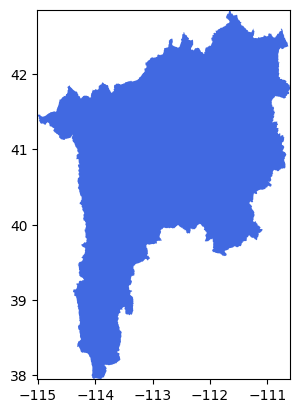

In [8]:
# Create a background map (this will plot on a map at the bottom so that the user can check that it looks right)
    # This background map is part of the geopandas library. The aquifers shapefile / geojson plots on top
print('Royal Blue = Primary Aquifers \nLight Blue = Secondary Aquifers (if applicable)')
if addAq == 2 and 'aq_gdf2' in globals(): background_map(aq_gdf, aq_gdf2)
elif addAq == 1: background_map(aq_gdf)
else: print("\nNo aquifers file added (wells will not be assigned an aquifer ID or name\nIf you wanted to assign aquifer IDs/names, go back to the parameters)")

In [9]:
# Re-import the time series and store in a dataframe. Rename and format the columns
ts_df = ts_df.rename(columns=({'site_no':'Well_ID', 'lev_dt':'Date', 'lev_tm':'Time', valueCol:'GW_measurement'}))
ts_df['GW_measurement'] = pd.to_numeric(ts_df['GW_measurement'])
ts_df = ts_df[['Well_ID', 'Date', 'GW_measurement']]

In [10]:
# Next we obtain the Wells from NWIS #

# Import the well data from NWIS. Clip the file and read to a Pandas Dataframe
wellsurl = "https://waterservices.usgs.gov/nwis/site/?format=rdb&stateCd="+mystate+"&siteType=GW&siteStatus=all"
w_df = pd.read_csv(wellsurl, comment='#', sep='\t', dtype=str)

# Drop unneccessary data, rename columns, and set data types
w_df = w_df.drop([0])
w_df = w_df.drop(['agency_cd', 'site_tp_cd', 'coord_acy_cd', 'dec_coord_datum_cd', 'alt_acy_va', 'alt_datum_cd', 'huc_cd'], axis=1)
w_df = w_df.rename(columns=({'site_no':'Well_ID', 'station_nm':'Well_Name', 'dec_lat_va':'lat_dec', 'dec_long_va':'long_dec', 'alt_va':'GSE'}))
w_df['long_dec'], w_df['lat_dec'] = pd.to_numeric(w_df['long_dec']), pd.to_numeric(w_df['lat_dec'])

# Compare to the Time series csv to extract only wells that actually have data in the specified year range (this allows for a smaller dataframe)
wells_df = pd.merge(w_df, ts_df["Well_ID"], on=['Well_ID'])
wells_df = wells_df.drop_duplicates(subset = 'Well_ID')

In [11]:
# Clip the wells with data in the date range to those that fall within the aquifers. #

if addAq < 3:
  # Create a GeoDataFrame from the wells dataframe
  wells_gdf = gpd.GeoDataFrame(wells_df, geometry=gpd.points_from_xy(wells_df.long_dec, wells_df.lat_dec))
  # Ensure that its Coordinate Reference System is WGS84 (ensures consistency between dataframes)
  wells_gdf.crs = ('epsg:4326')

  # Merge the wells and aquifers GeoDataFrames and drop the NAN values
      # This will give us the wells that fall within the aquifers
  wells_in_aq_gdf = gpd.sjoin(wells_gdf, aq_gdf, how='left', op='intersects')
  wells_in_aq_gdf = wells_in_aq_gdf.dropna(subset=[Aquifer_Name])
  wells_in_aq_gdf = wells_in_aq_gdf.rename(columns=({AquiferID:'AquiferID', Aquifer_Name:'Aquifer_Name'}))

  # Drop the unneccessary columns and set proper data types
  wells_in_aq_df = wells_in_aq_gdf.loc[:,('Well_ID', 'Well_Name', 'lat_dec', 'long_dec', 'GSE', 'AquiferID', 'Aquifer_Name')]
  wells_in_aq_df.loc[:,'AquiferID'] = wells_in_aq_df.loc[:,'AquiferID'].astype(int)
  wells_in_aq_df.loc[:, 'GSE'] = wells_in_aq_df.loc[:, 'GSE'].astype(float)

/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py:3473: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if (await self.run_code(code, result,  async_=asy)):


Map:
 - Green dots are wells inside the primary aquifer(s)
 - Red dots are wells outside primary aquifer(s)

7784 wells fell outside the primary aquifer(s) and will be dropped or reclassified (if applicable)


<ipython-input-7-390a7af34891>:4: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres')) # Background map is part of geopandas library


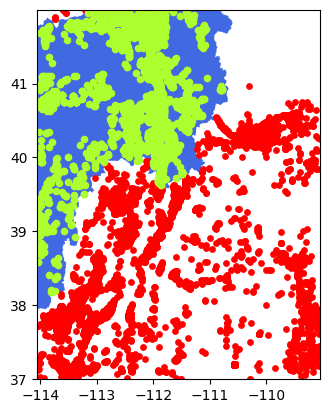

In [12]:
# Create a plot that shows the wells that fall within the aquifers
if addAq < 3:
  wDrop = len(wells_gdf) - len(wells_in_aq_gdf)
  print("Map:\n - Green dots are wells inside the primary aquifer(s)\n - Red dots are wells outside primary aquifer(s)\n\n%d wells fell outside the primary aquifer(s) and will be dropped or reclassified (if applicable)" %wDrop)
  if addAq_widget.value[0] == '2' and 'aq_gdf2' in globals():
    background_map(aq_gdf, aq_gdf2, wells=wells_gdf, wells_in_aquifer=wells_in_aq_gdf)
  else:
    background_map(aq_gdf, wells=wells_gdf, wells_in_aquifer=wells_in_aq_gdf)

In [13]:
# Add state column to well file (OPTIONAL) - add a "State" column to the ts_df and populate with state code.
# This is useful when an aquifer spans multiple states and you need to combine the files.
wells_in_aq_df['State'] = mystate

In [14]:
# Save the wells file as a csv file
if addAq < 3:
  wellsFileName = mystate+'_'+str(startDate.year)+'-'+str(endDate.year)+'_wells_with_aquifers.csv'
  wells_in_aq_df.to_csv (wellsFileName, index = None, header=True)
else:
  wellsFileName = mystate+'_'+str(startDate.year)+'-'+str(endDate.year)+'_wells.csv'
  wells_df.to_csv (wellsFileName, index = None, header=True)

# Save reclassified wells, if applicable
if addAq == 2 and wDrop > 0  and 'aq_gdf2' in globals():
  wls_out_aq_gdf = wells_gdf[~wells_gdf.isin(wells_in_aq_gdf)].dropna()
  wells_in_aq_gdf2 = gpd.sjoin(wls_out_aq_gdf, aq_gdf2[[AquiferID2, Aquifer_Name2, "geometry"]], how='left', op='within')
  wells_in_aq_gdf2 = wells_in_aq_gdf2.dropna(subset=[AquiferID2])
  wells_in_aq_gdf2 = wells_in_aq_gdf2.drop('index_right', axis=1)
  if len(wells_in_aq_gdf2) > 0:
    # Save the reclassified wells to a csv file
    wells_in_aq_gdf2.to_csv (mystate+'_'+str(startDate.year)+'-'+str(endDate.year)+'_wells_with_secondary_aquifers.csv', index = None, header=True)


In [15]:
# Clean up columns in time series dataframe.
if addAq < 3:
  # Merge ts_df with wells_in_aq_gdf to assign the aquifer id and name to each time series entry. Then drop unnecessary columns.
  ts_with_aq_df = ts_df.merge(wells_in_aq_df,on=['Well_ID'])

  # Recalculate the WTE using the GSE attribute of each well
  ts_with_aq_df['GSE'] = pd.to_numeric(ts_with_aq_df['GSE'])
  if lvl_ground == "Ft below ground surface":
      ts_with_aq_df['GW_measurement'] = ts_with_aq_df['GW_measurement'].abs()
      ts_with_aq_df['WTE'] = ts_with_aq_df.GSE - ts_with_aq_df.GW_measurement
  else:
      ts_with_aq_df['WTE'] = ts_with_aq_df['GW_measurement']
  ts_with_aq_df = ts_with_aq_df[['AquiferID', 'Well_ID', 'Date', 'WTE']]

In [18]:
# Cleanup time series dataframe (OPTIONAL)
# 1. delete rows in the ts_df where the WTE field is empty.
ts_with_aq_df.dropna(subset=['WTE'], inplace=True)
# 2. Round the WTE values to 2 decimal places to get rid of noise that shows up in the resulting CSV file
# for some of the entries (4216.0000000000001 for example).
ts_with_aq_df["WTE"] = ts_with_aq_df["WTE"].round(2)

In [19]:
# Add state column to time series file (OPTIONAL) - add a "State" column to the ts_with_aq_df and populate with state code.
# This is useful when an aquifer spans multiple states and you need to combine the files.
ts_with_aq_df['State'] = mystate

In [20]:
# Save the time series dataframe to a csv file
if addAq < 3:
  tsFileName = mystate+'_'+str(startDate.year)+'-'+str(endDate.year)+'_TS_with_aquifers.csv'
  ts_with_aq_df.to_csv (tsFileName, index = None, header=True)
else:
  tsFileName = mystate+'_'+str(startDate.year)+'-'+str(endDate.year)+'_TS.csv'
  ts_df.to_csv (tsFileName, index = None, header=True)

if 'wells_in_aq_gdf2' in globals():
  if len(wells_in_aq_gdf2) > 0:
    ts_with_aq_df2 = ts_df.merge(wells_in_aq_gdf2,on=['Well_ID'])
    # Recalculate the WTE using the GSE attribute of each well
    ts_with_aq_df2['GSE'] = pd.to_numeric(ts_with_aq_df2['GSE'])
    if lvl_ground == "Ft below ground surface":
        ts_with_aq_df2['GW_measurement'] = ts_with_aq_df2['GW_measurement'].abs()
        ts_with_aq_df2['WTE'] = ts_with_aq_df2.GSE - ts_with_aq_df2.GW_measurement
    else:
        ts_with_aq_df2['WTE'] = ts_with_aq_df2['GW_measurement']
    ts_with_aq_df2 = ts_with_aq_df2[['AquiferID', 'Well_ID', 'Date', 'WTE']]
    # Save csv file
    ts_with_aq_df2.to_csv (mystate+'_'+str(startDate.year)+'-'+str(endDate.year)+'_TS_with_secondary_aquifers.csv', index = None, header=True)

## **Retrieve Files**
#### Check the 'Files' panel on the left for your new files (hit the refresh button if they don't appear immediately) or run the cell below
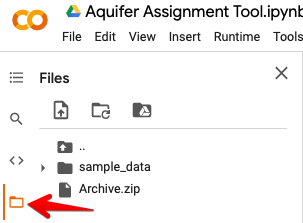

In [21]:
files.download(wellsFileName)
files.download(tsFileName)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>